In [1]:
import os
import datetime
from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/My Drive/Deep Learning CS6910/rnn_test')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# !pip install --upgrade wandb -qq

In [3]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import wandb
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from IPython.display import clear_output

In [4]:
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
path = './aksharantar_sampled/'
dirs = os.listdir(path)
# dirs

In [6]:
train_df = pd.read_csv(path+'hin'+'/'+'hin_train.csv', header=None)
print(train_df.head())
print(len(train_df))
train_data = train_df.values.T
train_data.shape

             0           1
0  shastragaar  शस्त्रागार
1      bindhya    बिन्द्या
2    kirankant    किरणकांत
3  yagyopaveet   यज्ञोपवीत
4      ratania     रटानिया
51200


(2, 51200)

In [7]:
valid_df = pd.read_csv(path+'hin'+'/'+'hin_valid.csv', header=None)
print(valid_df.head())
print(len(valid_df))
valid_data = valid_df.values

           0        1
0   jaisawal   जयसवाल
1      bajai     बजाई
2  sanghthan    संघठन
3    haiwaan    हैवान
4    nilgiri  नीलगिरि
4096


In [8]:
test_df = pd.read_csv(path+'hin'+'/'+'hin_valid.csv', header=None)
print(test_df.head())
print(len(test_df))
test_data = test_df.values.T

           0        1
0   jaisawal   जयसवाल
1      bajai     बजाई
2  sanghthan    संघठन
3    haiwaan    हैवान
4    nilgiri  नीलगिरि
4096


In [9]:
# storing all the alphabets of English and the pad char to a dictionary to create OHE representation later.
eng_alphabets = 'abcdefghijklmnopqrstuvwxyz'
pad_char = '-PAD-'

eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

print(eng_alpha2index)


{'-PAD-': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [10]:
tensor_dict = {key: torch.tensor(value).to(device_gpu) for key, value in eng_alpha2index.items()}

In [11]:
hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1

print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

In [12]:
import re
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

# Remove all English non-letters
def cleanEnglishVocab(line):
    line = line.replace('-', ' ').replace(',', ' ').upper()
    line = non_eng_letters_regex.sub('', line)
    return line.split()

# Remove all Hindi non-letters
def cleanHindiVocab(line):
    line = line.replace('-', ' ').replace(',', ' ')
    cleaned_line = ''
    for char in line:
        if char in hindi_alpha2index or char == ' ':
            cleaned_line += char
    return cleaned_line.split()

In [13]:

class TransliterationDataLoader(Dataset):
    def __init__(self, eng_words, hindi_words):
        self.eng_words = eng_words
        self.hindi_words = hindi_words
        self.shuffle_indices = list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0
        
    def __len__(self):
        return len(self.eng_words)
    
    def __getitem__(self, idx):
        return self.eng_words[idx], self.hindi_words[idx]
    
    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))
    
    def get_batch_from_array(self, batch_size, array):
        end = self.shuffle_start_index + batch_size
        batch = []
        if end >= len(self.eng_words):
            batch = [array[i] for i in self.shuffle_indices[0:end % len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]
    
    def get_batch(self, batch_size, postprocess=True):
        eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
        hindi_batch = self.get_batch_from_array(batch_size, self.hindi_words)
        self.shuffle_start_index += batch_size + 1
        
        if self.shuffle_start_index >= len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
            
        return eng_batch, hindi_batch


In [14]:
train_data = TransliterationDataLoader(train_data[0],train_data[1])

In [15]:
for i in range(10):
  eng, hindi = train_data.get_random_sample()
  print(eng + ' - ' + hindi)

falaisa - फलैसा
vranarodhak - व्रणरोधक
kokatu - कोकाटू
bhrikutiyaan - भृकुटियाँ
danissa - दानिसा
senthilkumar - संेतिलकुमार
gunahkar - गुनाहकर
lemahiu - लेमाहियू
sheeghragami - शीघ्रगामी
sapolon - सपोलों


In [16]:
def word_rep(word, letter2index, device = 'cpu'):
    rep = torch.zeros(len(word)+1, 1, len(letter2index)).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][0][pos] = 1
    pad_pos = letter2index[pad_char]
    rep[letter_index+1][0][pad_pos] = 1
    return rep

def gt_rep(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return gt_rep

In [17]:
eng, hindi = train_data.get_random_sample()
eng_rep = word_rep(eng, eng_alpha2index)
# print(eng, eng_rep)

In [18]:
hindi_gt = gt_rep(hindi, hindi_alpha2index)
print(hindi, hindi_gt.shape[0])

स्थितों 8


In [30]:
MAX_OUTPUT_CHARS = 30

class Transliteration_EncoderDecoder_Attention(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, verbose=False):
        super(Transliteration_EncoderDecoder_Attention, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        self.U = nn.Linear(self.hidden_size, self.hidden_size)
        self.W = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, 1)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)   
        
        self.verbose = verbose
        
    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        attention_matrices = [] 
        # encoder
        encoder_outputs, hidden = self.encoder_rnn_cell(input)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
        
        if self.verbose:
            print('Encoder output', encoder_outputs.shape)
        
        # decoder
        decoder_state = hidden
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        
        outputs = []
        U = self.U(encoder_outputs)
        
        if self.verbose:
            print('Decoder state', decoder_state.shape)
            print('Decoder intermediate input', decoder_input.shape)
            print('U * Encoder output', U.shape)
        
        for i in range(max_output_chars):
            
            W = self.W(decoder_state.view(1, -1).repeat(encoder_outputs.shape[0], 1))
            V = self.attn(torch.tanh(U + W))
            attn_weights = F.softmax(V.view(1, -1), dim = 1) 
            
            if self.verbose:
                print('W * Decoder state', W.shape)
                print('V', V.shape)
                print('Attn', attn_weights.shape)

            attention_matrices.append(attn_weights.cpu().detach().numpy())
            
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            
            embedding = self.out2hidden(decoder_input)
            decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0)
            
            if self.verbose:
                print('Attn LC', attn_applied.shape)
                print('Decoder input', decoder_input.shape)
                
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            
            if self.verbose:
                print('Decoder intermediate output', out.shape)
                
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            
            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False
            
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1) 
            
            decoder_input = one_hot.detach()
            
        return outputs,np.array(attention_matrices)

In [20]:
def infer(net, eng_word,shape,device ='cpu'):
  # net.eval()
  net.to(device)
  input_ = word_rep(eng_word,tensor_dict,device) # convert the name into one hot encoding.
  outputs,_ = net(input_,shape,device) # initilise the hidden layer.
  
  return outputs

In [21]:
net = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index), 256, len(hindi_alpha2index), verbose=True)

In [22]:
out = infer(net, 'india', 30, device_gpu)
# type(out)

Encoder output torch.Size([6, 256])
Decoder state torch.Size([1, 1, 256])
Decoder intermediate input torch.Size([1, 1, 129])
U * Encoder output torch.Size([6, 256])
W * Decoder state torch.Size([6, 256])
V torch.Size([6, 1])
Attn torch.Size([1, 6])
Attn LC torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 512])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])


In [23]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):
    
  net.train().to(device)
  opt.zero_grad()
  eng_batch, hindi_batch = train_data.get_batch(batch_size)
  
  total_loss = 0
  accuracy = 0
  for i in range(batch_size):
      
    input = word_rep(eng_batch[i], eng_alpha2index, device)
    gt = gt_rep(hindi_batch[i], hindi_alpha2index, device)
    outputs,attention_matrix = net(input, gt.shape[0], device, ground_truth = gt if teacher_force else None)
    
    correct = 0
    for index, output in enumerate(outputs):
      loss = criterion(output, gt[index]) / batch_size
      loss.backward(retain_graph = True)
      total_loss += loss

      val, indices = output.topk(1)
      hindi_pos = indices.tolist()[0]
      if hindi_pos[0] == gt[index][0]:
        correct += 1
    accuracy += correct/gt.shape[0]
  accuracy /= batch_size
  opt.step()


  return total_loss.cpu().detach().numpy()/batch_size,accuracy,attention_matrix

In [24]:
def calc_accuracy(net,Data, device = 'cpu'):
  net = net.eval()#.to('cpu')
  predictions = []
  accuracy = 0
  for i in range(len(Data)):
    data = Data[i]
    eng, hindi = data[0],data[1]
    gt = gt_rep(hindi, hindi_alpha2index, device_gpu)
    outputs = infer(net, eng, gt.shape[0], device_gpu)
    correct = 0
    for index, out in enumerate(outputs):
      val, indices = out.topk(1)
      hindi_pos = indices.tolist()[0]
      if hindi_pos[0] == gt[index][0]:
        correct += 1      
    accuracy += correct/gt.shape[0]
  accuracy /= len(Data)
  # print(accuracy)
  return accuracy

In [25]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu',name='model'):

  log = {}
    
  net = net.to(device)
  criterion = nn.NLLLoss(ignore_index = -1)
  opt = optim.Adam(net.parameters(), lr=lr)
  teacher_force_upto = n_batches//3
  
  # loss_arr = np.zeros(n_batches + 1)
  
  for i in range(n_batches):
    loss,accuracy,attention_matrix = train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto )
    print(attention_matrix.shape)

    log['loss'] = loss
    log['acc'] = accuracy
    
    # if i%display_freq == display_freq-1:
    #     clear_output(wait=True)
        
    #     print('Iteration', i, 'Loss', loss,'accuracy:',accuracy)
        # plt.figure()
        # plt.plot(loss, '-*')
        # plt.xlabel('Iteration')
        # plt.ylabel('Loss')
        # plt.show()
        # print('\n\n')

    val_acc = calc_accuracy(net,valid_data) 
    log['val_acc'] = val_acc

    if i==n_batches-1:
      fig, ax = plt.subplots(figsize=(8, 8))
      ax.imshow(attention_matrix, cmap='hot', interpolation='nearest')
      ax.set_xlabel('Source')
      ax.set_ylabel('Target')
      plt.close(fig)
      log['attention']=wandb.Image(fig)

    wandb.log(log)
    # print('val_acc',val_acc)    
  torch.save(net, name+'.pt')
  # return loss

In [31]:
net = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index), 256, len(hindi_alpha2index))

In [ ]:
wandb.init(project="CS6910_NLG", entity="viswa_ee")
wandb.run.name = 'NLG_Attention'

In [ ]:
train_setup(net, lr=0.001, n_batches=2000, batch_size = 64, display_freq=5, device = device_gpu,name='NLG_Attention')

In [29]:
# torch.save(net, 'NLG_Attention.pt')

In [32]:
net = torch.load('NLG_Attention.pt')

In [43]:
def test(net, word, device = 'cpu'):
    net = net.eval().to(device)
    outputs,_ = infer(net, word, 30, device)
    hindi_output = ''
    for out in outputs:
        val, indices = out.topk(1)
        index = indices.tolist()[0][0]
        if index == 0:
            break
        hindi_char = hindi_alphabets[index+1]
        hindi_output += hindi_char
    # print(word + ' - ' + hindi_output)
    return hindi_output

In [37]:
def infer(net, eng_word,shape,device ='cpu'):
  # net.eval()
  net.to(device)
  input_ = word_rep(eng_word,tensor_dict,device) # convert the name into one hot encoding.
  outputs,attn_weights = net(input_,shape,device) # initilise the hidden layer.
  
  return outputs,attn_weights

In [38]:
out,attn_weights =infer(net, 'india', 30, device_gpu)


In [44]:
pred=np.array([])
for i in range(4096):
  pred =np.append(pred,test(net,test_data[0][i]))

jaisawal - रीलॏली
bajai - गीऴी
sanghthan - रीलॏलीली
haiwaan - रीलीप
nilgiri - रीलॏलीप
drutgrami - रॏलॏलॏलॏलीप
jhadapon - रीलीली
nakronda - रीलॏलील
eesl - गीऴू
bachta - गीली
vodka - गीऴी
kristian - रॏलॏलॏलीप
guanajuata - रॏलॏलॏलीली
shershi - रीलील
mannaki - रीलीली
jimmaa - रीलीप
yun - गीऴ
baig - गीऴ
marsi - गीली
pus - गीऴ
charmful - रीलॏलीप
sriperu - रीलॏलील
russio - रीलीली
ihfl - गीऴू
ganinath - रीलॏलीप
bandikui - रीलॏलीप
lasalle - रीलीली
namdan - रीलीप
decaine - रीलीली
redesign - रॏलॏलॏलीप
holobon - रीलीप
ilakon - रीलीप
aashcharyajanak - रॏलॏलॏलॏलॏलॏली
krus - गीलू
option - रीलीप
mahal - गीऴी
recapitalization - रॏलॏलॏलॏलॏलॏलॏलॏली
bordo - गीली
manmaana - रीलॏलीप
kaagajo - रीलीप
paapaa - रीली
jatbaada - रीलीली
sthiti - रीलीप
khankarmi - रीलॏलील
upmukhyamantri - रॏलॏलॏलॏलॏलॏलॏली
ron - गीऴ
familease - रॏलॏलॏलील
haklaate - रीलीली
naksalavaadiyon - रॏलॏलॏलॏलॏलॏलॏली
jatiltaon - रीलॏलीली
chikkamagaluru - रॏलॏलॏलॏलॏलॏली
antarkalah - रॏलॏलॏलॏली
surkshit - रीलॏलीली
blutic - रीलील
ghisen - गीली
le

In [45]:
import csv

def write_predictions_to_csv(predictions, actual_values, filename):
    # Prepare data as a list of dictionaries
    data = [{'predicted': pred, 'actual': actual} for pred, actual in zip(predictions, actual_values)]

    # Write data to CSV file
    with open(filename, 'w', newline='') as file:
        fieldnames = ['predicted', 'actual']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(data)

In [46]:
write_predictions_to_csv(pred,test_data[1],'predictions_attention.csv')

In [61]:
pred_array = []
attn_weights = []
for i in range(9):
  out,attn =infer(net, test_data[0][i], len(test_data[0][i]), device_gpu)
  pred_array.append(out)
  attn_weights.append(attn.reshape(attn.shape[0],attn.shape[2]))

In [72]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_heatmaps(attention_weights, source_texts, target_texts):
    num_examples = len(attention_weights)
    fig, axs = plt.subplots(num_examples, 1, figsize=(10, num_examples*4))

    for i in range(num_examples):
        ax = axs[i]
        ax.imshow(attention_weights[i], cmap='hot', interpolation='nearest')

        # ax.set_xticks(np.arange(len(target_texts[i])))
        # ax.set_yticks(np.arange(len(source_texts[i])))

        # ax.set_xticklabels(list(target_texts[i]))
        # ax.set_yticklabels(list(source_texts[i]))

        ax.set_xlabel('Target', fontsize=12)
        ax.set_ylabel('Source', fontsize=12)

    plt.tight_layout()
    plt.show()

In [75]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_heatmaps(attention_weights, source_texts, target_texts):
    num_examples = len(attention_weights)
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))

    for i in range(num_examples):
        row = i // 3
        col = i % 3
        ax = axs[row, col]
        ax.imshow(attention_weights[i], cmap='hot', interpolation='nearest')

        ax.set_xlabel('Target', fontsize=12)
        ax.set_ylabel('Source', fontsize=12)

    plt.tight_layout()
    plt.show()


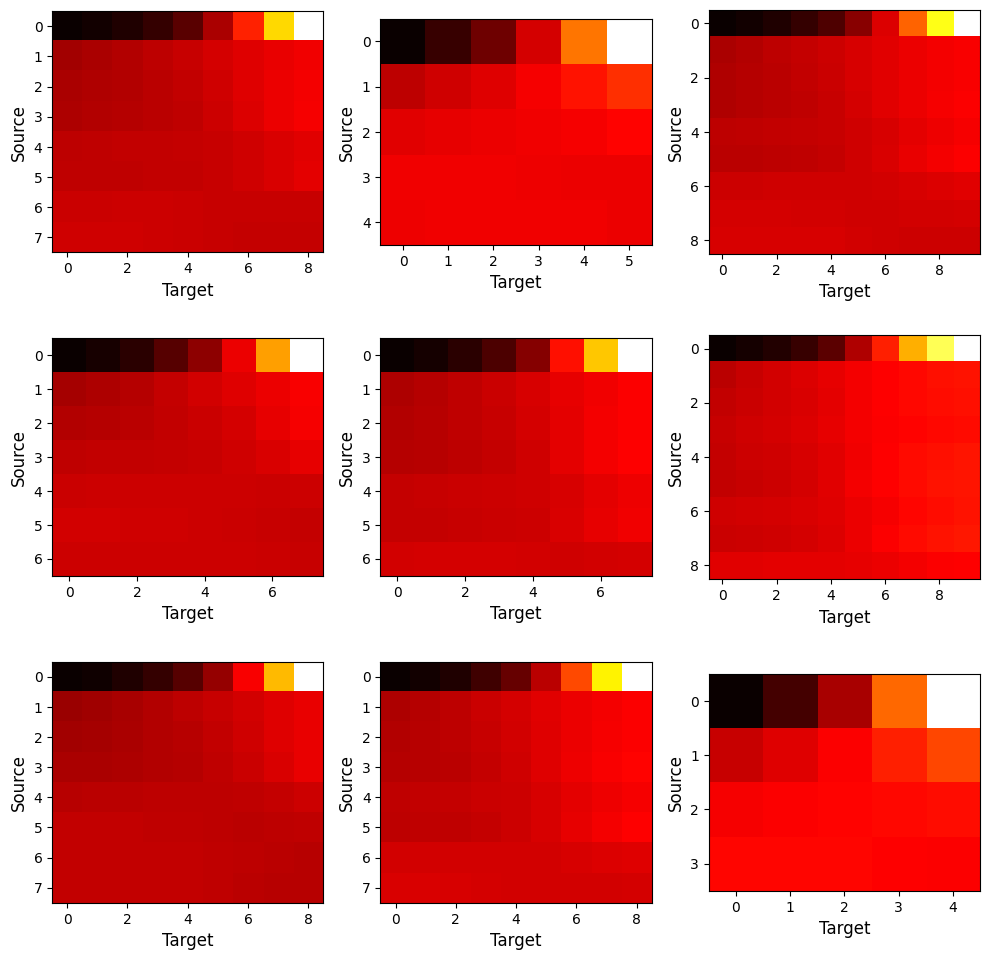

In [76]:
plot_attention_heatmaps(attn_weights,test_data[0][0:9],pred_array)